In [1]:
import pickle as pkl
from robot_library_py import *
import rclpy
from rclpy.node import Node
from sensor_msgs.msg import Joy, JointState
from intera_core_msgs.msg import JointCommand

from threading import Thread
import time
import numpy as np 
from std_msgs.msg import Bool
import rotm2euler

from utils_camera import MyRealSense, CVCamera
import cv2
from matplotlib import pyplot as plt
import glob
import h5py
import os

### Try: load all the .pkl files and save them into a single .h5 file

In [2]:
dir='/media/ns/DatasetDrive/data_sawyer/spoon/'

In [3]:
files=glob.glob(dir+'*.pkl')
len(files)

23

In [4]:
files=files[:12]  # first 12 files

In [5]:
def load_demo_pkl(demo_name):
    with open(demo_name, 'rb') as f:
        demo = pkl.load(f)
    msgs=demo['msgs']
    imgs=demo['imgs']
    grips=demo['grips']
    return msgs, imgs, grips

In [6]:
demo_name=files[0]
msgs, imgs, grips = load_demo_pkl(demo_name)

print(len(msgs), len(imgs), len(grips))

393 393 393


In [49]:
def save_demo_hdf5(hdf5_file_name, demo_name, msgs, imgs, grips):
    with h5py.File(hdf5_file_name, 'a') as hf:
        group = hf.create_group("data/"+demo_name)
        # group.create_dataset('msgs', data=msgs)
        group.create_dataset('imgs', data=imgs)
        group.create_dataset('grips', data=grips)

In [43]:
hdf5_file_name=dir+'demo.hdf5'

In [44]:
demo_name="demo_1"
msgs, imgs, grips = load_demo_pkl(files[0])
save_demo_hdf5(hdf5_file_name, demo_name, msgs, imgs, grips)

In [50]:
demo_name="demo_2"
 
msgs, imgs, grips = load_demo_pkl(files[1])
save_demo_hdf5(hdf5_file_name, demo_name, msgs, imgs, grips)

In [24]:
msgs[0]

sensor_msgs.msg.JointState(header=std_msgs.msg.Header(stamp=builtin_interfaces.msg.Time(sec=1694745822, nanosec=1027936), frame_id=''), name=['head_pan', 'right_j0', 'right_j1', 'right_j2', 'right_j3', 'right_j4', 'right_j5', 'right_j6', 'torso_t0'], position=[-1.0244140625, 0.357806640625, 0.21978515625, -1.8408271484375, 1.0465771484375, -1.2126650390625, -1.7039912109375, -3.5998935546875, 0.0], velocity=[-0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, 0.0], effort=[-0.012, -0.848, -34.756, -9.344, 4.276, -3.084, 0.512, 0.264, 0.0])

In [123]:
# file_path = 'multiple_demonstrations.h5'
file_path = hdf5_file_name
file=h5py.File(file_path, 'r') 
file.keys()

<KeysViewHDF5 ['data', 'obs']>

<KeysViewHDF5 ['data']>

In [53]:
file['data'].keys()

<KeysViewHDF5 ['demo_1', 'demo_2']>

In [124]:
file.close()

In [29]:
urdf_path = os.getcwd() +'/'+'sawyer.urdf'  #'/home/carl/sawyer_robot_ros2/src/teleop_script/sawyer.urdf'
robot = URDFModel(urdf_path)
jointMap = {name: ind for ind, name in enumerate(robot.jointNames)}

joint_names=['right_j0', 'right_j1', 'right_j2', 'right_j3', 'right_j4', 'right_j5', 'right_j6']
joint_inds=[jointMap[name] for name in joint_names]

sawyer
link: 0
	cog: 0 0 0
	inertia: 1 1 1 0 0 0
	mass: 1
	name: base
link: 1
	cog: 0 0 0
	inertia: 1e-08 1e-08 1e-08     0     0     0
	mass: 0.0001
	name: torso
link: 2
	cog:    0    0 -0.5
	inertia:    5.06359    6.08689    4.96192 0.00105311   0.801996 0.00103417
	mass: 60.864
	name: pedestal
link: 3
	cog: 0 0 0
	inertia: 1 1 1 0 0 0
	mass: 1
	name: controller_box
link: 4
	cog: 0 0 0
	inertia: 1 1 1 0 0 0
	mass: 1
	name: pedestal_feet
link: 5
	cog:  -0.0006241 -2.8025e-05    0.065404
	inertia:   0.0067599   0.0067877   0.0074031  1.5888e-05 -6.1904e-07 -4.2024e-05
	mass: 2.0687
	name: right_arm_base_link
link: 6
	cog: 0.024366 0.010969  0.14363
	inertia:  0.053314  0.057902  0.023659 0.0080179  0.011734 0.0047093
	mass: 5.3213
	name: right_l0
link: 7
	cog:   0.0053207 -2.6549e-05      0.1021
	inertia:    0.011833   0.0082709   0.0049661  4.2124e-07  4.9425e-05 -4.4669e-06
	mass: 1.5795
	name: head
link: 8
	cog: 0 0 0
	inertia: 1e-08 1e-08 1e-08     0     0     0
	mass: 0.0001
	name

In [10]:
def get_ee(jointmsg):
    msg=jointmsg    
    q =  robot.getJoints() 
    for ind, name in enumerate(msg.name):
        if name in jointMap:
            q[jointMap[name]] = msg.position[ind]
    robot.setJoints(q)
    
    # T=robot.getBodyTransform('right_l6');
    T=robot.getBodyTransform('camera_link');
    xyz=T[0:3,3]
    e1 = rotm2euler.rotationMatrixToEulerAngles(T[0:3, 0:3])
    ee6=np.concatenate([xyz, e1])
    return ee6

In [42]:
# msg=msgs[0]
# grip=grips[0]
# img=imgs[0]

In [51]:
# ee=get_ee(msg)

# pos =np.array( [msg.position[ind] for ind in joint_inds] )
# vel =np.array( [msg.velocity[ind] for ind in joint_inds] )
# t=msg.header.stamp.sec+msg.header.stamp.nanosec*1e-9

# ee.shape, pos.shape, vel.shape ,t

((6,), (7,), (7,), 1694745822.0010278)

In [71]:
msgs, imgs, grips = load_demo_pkl(demo_name)

In [108]:
def extract_data(msgs, imgs, grips):
    '''
    msgs: list of joint msgs
    imgs: list of images
    grips: list of gripper states

    msgs are ros msgs 
    similar to matlab code, robot library (rl) is needed to convert msgs to end effector pose
    '''
    
    poss, vels, ees, ts, imgs_wrist, imgs_front=[], [], [], [], [], []

    for i in range(len(msgs)-1):  #remove the last element, as ee is delta_ee
        msg=msgs[i]
        img_wrist, img_front=imgs[i]

        ee=get_ee(msg)
        next_ee=get_ee(msgs[i+1])
        delta_ee=next_ee -ee

        pos =[msg.position[ind] for ind in joint_inds] 
        vel =[msg.velocity[ind] for ind in joint_inds] 
        t=msg.header.stamp.sec+msg.header.stamp.nanosec*1e-9

        poss.append(pos)
        vels.append(vel)
        ees.append(delta_ee)
        ts.append(t)

        # to rgb
        img_wrist=cv2.cvtColor(img_wrist, cv2.COLOR_BGR2RGB)
        img_front=cv2.cvtColor(img_front, cv2.COLOR_BGR2RGB)
        
        img_wrist=cv2.resize(img_wrist, (84,84))
        img_front=cv2.resize(img_front, (84,84))

        imgs_wrist.append(img_wrist)
        imgs_front.append(img_front)

    poss=np.array(poss)
    vels=np.array(vels)
    ees=np.array(ees)
    ts=np.array(ts)
    imgs_wrist=np.array(imgs_wrist)
    imgs_front=np.array(imgs_front)

    grips =np.array(grips[:-1], dtype=np.int8)  

    return poss, vels, ees, ts, imgs_wrist, imgs_front, grips

In [115]:
print(demo_name)

msgs, imgs, grips = load_demo_pkl(demo_name)
poss, vels, ees, ts, imgs_wrist, imgs_front, grips = extract_data(msgs, imgs, grips)
robomimic_action=np.hstack([ees, grips.reshape(-1,1)])

poss.shape, vels.shape, ees.shape, ts.shape, imgs_wrist.shape, imgs_front.shape, grips.shape, robomimic_action.shape

/media/ns/DatasetDrive/data_sawyer/spoon/09_14_2023_22_43_0.048255205154418945_393.pkl


((392, 7),
 (392, 7),
 (392, 6),
 (392,),
 (392, 84, 84, 3),
 (392, 84, 84, 3),
 (392,),
 (392, 7))

In [125]:
hdf5_file_name=dir+'demo_block.hdf5'
hdf5_file_name

'/media/ns/DatasetDrive/data_sawyer/spoon/demo_block.hdf5'

In [126]:
def save_to_robomimic_like_hdf5(hdf5_file_name, demo_no, poss, vels, ees, ts, imgs_wrist, imgs_front, actions):

    demo_group=f"/data/demo_{demo_no}"
    print(f'saving demo {demo_group} to {hdf5_file_name}')
    with h5py.File(hdf5_file_name, 'a') as hf:
        group = hf.create_group(demo_group) 
        group.attrs['num_samples'] = poss.shape[0]
        group.create_dataset('obs/robot0_eef_pos', data=ees)
        group.create_dataset('obs/robot0_eye_in_hand_image', data=imgs_wrist)
        group.create_dataset('obs/agentview_image', data=imgs_front)
        group.create_dataset('obs/robot0_joint_pos', data=poss)
        group.create_dataset('obs/robot0_joint_vel', data=vels)
        group.create_dataset('actions', data=actions)
        group.create_dataset('times', data=ts)

In [127]:
save_to_robomimic_like_hdf5(hdf5_file_name, 1, poss, vels, ees, ts, imgs_wrist, imgs_front, robomimic_action)

saving demo /data/demo_1 to /media/ns/DatasetDrive/data_sawyer/spoon/demo_block.hdf5


In [137]:
demo_name=files[1]
print(demo_name)

msgs, imgs, grips = load_demo_pkl(demo_name)
poss, vels, ees, ts, imgs_wrist, imgs_front, grips = extract_data(msgs, imgs, grips)
robomimic_action=np.hstack([ees, grips.reshape(-1,1)])

poss.shape, vels.shape, ees.shape, ts.shape, imgs_wrist.shape, imgs_front.shape, grips.shape, robomimic_action.shape

/media/ns/DatasetDrive/data_sawyer/spoon/09_14_2023_22_51_0.035153865814208984_500.pkl


((499, 7),
 (499, 7),
 (499, 6),
 (499,),
 (499, 84, 84, 3),
 (499, 84, 84, 3),
 (499,),
 (499, 7))

In [140]:
save_to_robomimic_like_hdf5(hdf5_file_name, 2, poss, vels, ees, ts, imgs_wrist, imgs_front, robomimic_action)

saving demo /data/demo_2 to /media/ns/DatasetDrive/data_sawyer/spoon/demo_block.hdf5


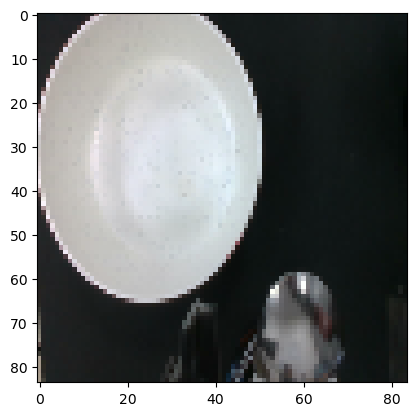

In [112]:
img=imgs_front[0]
img=imgs_wrist[0]

plt.imshow(img)

### verify

In [10]:
# file_path = hdf5_file_name

file_path = "/home/carl/data_sawyer/block/demos.hdf5"
file=h5py.File(file_path, 'r') 
file.keys()

<KeysViewHDF5 ['data']>

In [11]:
len(file['data'].keys())

25

In [12]:
file['data'].keys()

<KeysViewHDF5 ['demo_0', 'demo_1', 'demo_10', 'demo_11', 'demo_12', 'demo_13', 'demo_14', 'demo_15', 'demo_16', 'demo_17', 'demo_18', 'demo_19', 'demo_2', 'demo_20', 'demo_21', 'demo_22', 'demo_23', 'demo_24', 'demo_3', 'demo_4', 'demo_5', 'demo_6', 'demo_7', 'demo_8', 'demo_9']>

In [13]:
file['data']['demo_1'].keys()

<KeysViewHDF5 ['actions', 'obs', 'times']>

In [14]:
file['data']['demo_1']['obs'].keys()

<KeysViewHDF5 ['agentview_image', 'robot0_eef_pos', 'robot0_eye_in_hand_image', 'robot0_joint_pos', 'robot0_joint_vel']>

In [15]:
file['data']['demo_2'].attrs['num_samples']

245

In [22]:
demo_name="demo_1"
obs=file['data'][demo_name]['obs']

i=0
image_wrist=obs['robot0_eye_in_hand_image'][i]
image_front=obs['agentview_image'][0]

image=np.concatenate([image_wrist, image_front], axis=1)

image.shape

(84, 168, 3)

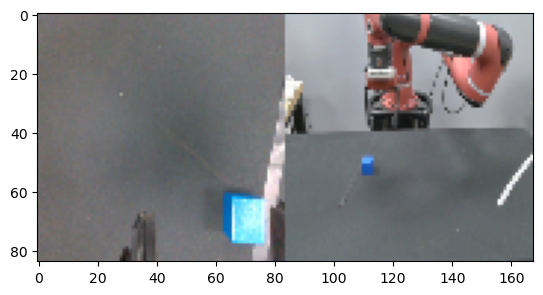

In [23]:
plt.imshow(image)

In [24]:
file.close()